# Stimulus playground
This script is a playground to inspect and manipulate stimuli for a binocular rivalry (BR) experiment<br>
In this experiment (as at April th) I aim to present objects that are associated with a color (e.g., banana - yellow, strawberry - red) in rivarous situations.<br>
1. Show the same stimulus either in the "correct" and in an "incorrect" color (a banana in yellow and blue)
2. Show two different stimuli that are associated with different colors but in the same color (a banana and a strawberry both in yellow)

Compare the onset and sustained dominance with rivaling gratings that follow a series of non-rivaling gratings that appear to be rotating (Denison et al., 2011, Attarha et al., 2015)

## Stimuli
In the following I will look at the stimuli used by Teichmann et al., 2020

In [1]:
# import libraries

# use the os
import os
import glob
# math and data structure
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
# image processing
import cv2

In [261]:
# stimuli from Teichmann et al., 2020
# provided by her OSF site (https://osf.io/tcqjh/)
stim_dir = os.path.join('..','stimuli')
original_stim_dir = os.path.join(stim_dir,'original')
grey_stim_dir = os.path.join(stim_dir,'grey') # not used yet
# get a list of all stimuli in the directory
stimuli_full_path = glob.glob(os.path.join(original_stim_dir,'*.png'))
stimuli_full_path.sort()

# extract the image name from the stimulus path
stimuli = [os.path.basename(stim) for stim in stimuli_full_path]

# taken from original - added alpha channel
true_color_stim_dir = os.path.join(stim_dir,'true_color')
# increased saturation for stimuli to prevent color fusion
max_saturation_stim_dir = os.path.join(stim_dir,'max_saturation')
if not os.path.exists(max_saturation_stim_dir):
    os.mkdir(max_saturation_stim_dir)
# stimuli in HLS space inverted
inverted_hue_stim_dir = os.path.join(stim_dir,'inverted_hue')
if not os.path.exists(inverted_hue_stim_dir):
    os.mkdir(inverted_hue_stim_dir)
# stimuli in LAB space inverted
inverted_lab_stim_dir = os.path.join(stim_dir,'inverted_lab')
if not os.path.exists(inverted_lab_stim_dir):
    os.mkdir(inverted_lab_stim_dir)
# stimuli in LUV space inverted
inverted_luv_stim_dir = os.path.join(stim_dir,'inverted_luv')
if not os.path.exists(inverted_luv_stim_dir):
    os.mkdir(inverted_luv_stim_dir)
# masks
mask_dir = os.path.join(stim_dir,'masks')
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
    
    
# where results of image analyses are saved
results_dir = os.path.join(stim_dir,'analysis')
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
ab_dist_plot_dir = os.path.join(results_dir, 'ab_distance')
if not os.path.exists(ab_dist_plot_dir):
    os.mkdir(ab_dist_plot_dir)
uv_dist_plot_dir = os.path.join(results_dir, 'uv_distance')
if not os.path.exists(uv_dist_plot_dir):
    os.mkdir(uv_dist_plot_dir)
hue_dist_plot_dir = os.path.join(results_dir, 'hue_distributions')
if not os.path.exists(hue_dist_plot_dir):
    os.mkdir(hue_dist_plot_dir)

### Note
Some of the stimuli taken from Teichmann were prepared with the following cell, but created "wholes" in the stimuli, because these had pure white pixels in the foreground.<br>
The "wholes" within the images were filled using GIMP and replaced the originals.<br>
The true originals that were replaced are now located in `original_exchanged`

In [262]:
# read out the original stimuli and remove the background
for stim_path, stim in zip(stimuli_full_path, stimuli):
    # output directories
    true_color_output_dir = os.path.join(true_color_stim_dir, stim)
    
    # read in the original image
    img = cv2.imread(stim_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to isolate the non-white pixels
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find the contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a binary mask for the largest contour
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), cv2.FILLED)

    # Create a binary mask with the pixels inside the contour set to white
    # and the pixels outside the contour set to black
    binary_mask = cv2.inRange(mask, 255, 255)
    
    # convert image from BGR to HLS space
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # The contour also captures empty space surrounded by object boundaries
    # We therefore add a mask that includes all pixels with a luminance value of 255 -> white
    white_mask = hls_img[:,:,1]==255
    big_mask = np.logical_or(white_mask, ~binary_mask)
    
    # add alpha channel to original image by converting from BGR to BGRA space
    bgra_img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    
    # change alpha channel of all pixels that are white to completely transparent
    # CAUTION this results in pixels that are part of the stimulus to be transparent. 
    bgra_img[big_mask == 1] = np.array([255,255,255,0],dtype='uint8') 
    cv2.imwrite(true_color_output_dir,bgra_img)

## Invert the color in the stimuli
This is not performed in the same step because some minor adjustments were made in the true color stimuli using GIMP

In [316]:
def calc_dist(dim1, dim2, mask):
    # Extract the values from dim1 and dim2 where mask is 0
    dim1_flat = dim1[~mask]
    dim2_flat = dim2[~mask]
    # Stack the extracted values column-wise to form a 2D array
    true_dims = np.column_stack((dim1_flat,dim2_flat)).astype('uint8')

    # Invert dim1 and dim2 using 255 - dim
    dim1_inv = 255 - dim1
    dim2_inv = 255 - dim2
    # Extract the inverted values from dim1_inv and dim2_inv where mask is 0
    dim1_inv_flat = dim1_inv[~mask]
    dim2_inv_flat = dim2_inv[~mask]
    # Stack the extracted inverted values column-wise to form a 2D array
    inv_dims = np.column_stack((dim1_inv_flat, dim2_inv_flat)).astype(int)

    # Compute the Euclidean distance between each pair of points in true_dims and inv_dims
    distances = np.sqrt((true_dims-inv_dims)**2).sum(axis=1)
    
    # Return the computed distances
    return distances

stimuli_full_path = glob.glob(os.path.join(true_color_stim_dir,'*.png'))
stimuli_full_path.sort()

# extract the image name from the stimulus path
stimuli = [os.path.basename(stim) for stim in stimuli_full_path]

my_dict = {
    'stim': stimuli,
    'min_uv_dist': [],
    'max_uv_dist': [],
    'mean_uv_dist': [],
    'median_uv_dist': [],
    'min_ab_dist': [],
    'max_ab_dist': [],
    'mean_ab_dist': [],
    'median_ab_dist': []
}

for stim in stimuli:
    # output directories
    true_color_input_dir = os.path.join(true_color_stim_dir, stim)
    max_saturation_output_dir = os.path.join(max_saturation_stim_dir, stim)
    inverted_hue_output_dir = os.path.join(inverted_hue_stim_dir, stim)
    inverted_lab_output_dir = os.path.join(inverted_lab_stim_dir, stim)
    inverted_luv_output_dir = os.path.join(inverted_luv_stim_dir, stim)
    
    # read in the original image
    img = cv2.imread(true_color_input_dir)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to isolate the non-white pixels
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find the contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a binary mask for the largest contour
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), cv2.FILLED)

    # Create a binary mask with the pixels inside the contour set to white
    # and the pixels outside the contour set to black
    binary_mask = cv2.inRange(mask, 255, 255)
    
    # convert image from BGR to HLS space
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # increase saturation 
    H,L,S = cv2.split(hls_img)
    S_high = S + 255 - S.max()
    hls_img = cv2.merge((H,L,S_high))
    # create image with max saturation values
    max_saturation_img = cv2.cvtColor(hls_img,cv2.COLOR_HLS2BGR)
    # convert into LAB and LUV space for inversion
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    luv_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
    # The contour also captures empty space surrounded by object boundaries
    # We therefore add a mask that includes all pixels with a luminance value of 255 -> white
    white_mask = hls_img[:,:,1] != 255
    # black_mask = hls_img[:,:,1]==0
    big_mask = np.logical_and(white_mask, binary_mask)
    
    # save the big mask
    big_mask_img = big_mask.astype(np.uint8)*255
    cv2.imwrite(os.path.join(mask_dir,stim), big_mask_img)
    
    # create a histogram of the hue values in the image for later mask creation
    fig = plt.figure()
    plt.hist(H[big_mask],bins=50)
    plt.savefig(os.path.join(hue_dist_plot_dir,stim))
    plt.close(fig=fig)

    # create a copy of the hls_img and invert the hue
    inverted_hls_img = np.copy(hls_img)
    # select all pixels that are not white and increase the hue value by 90 (hue ranges from 0-179)
    inverted_hls_img[np.where(binary_mask != 0)]+=np.array([90,0,0],dtype='uint8')
    # Split the L*a*b* image into its channels
    L, a, b = cv2.split(lab_img)
    # Invert the a and b channels
    a_inv = 255 - a
    b_inv = 255 - b
    
    # get distances
    # ab_distances = calc_dist(a,b,big_mask)
    # my_dict['min_ab_dist'].append(ab_distances.min())
    # my_dict['max_ab_dist'].append(ab_distances.max())
    # my_dict['mean_ab_dist'].append(ab_distances.mean())
    # my_dict['median_ab_dist'].append(np.median(ab_distances))
    
    # plot histogram of distances
    fig = plt.figure()
    plt.hist(ab_distances,bins=50)
    plt.savefig(os.path.join(ab_dist_plot_dir,stim))
    plt.close(fig=fig)

    # Merge the inverted channels back into the L*a*b* image
    inverted_lab_img = cv2.merge((L, a_inv, b_inv))
    
    # do the same for LUV space
    L, u, v = cv2.split(luv_img)
    u_inv = 255 - u
    v_inv = 255 - v
    
    # uv_distances = calc_dist(u,v,big_mask)
    # my_dict['min_uv_dist'].append(uv_distances.min())
    # my_dict['max_uv_dist'].append(uv_distances.max())
    # my_dict['mean_uv_dist'].append(uv_distances.mean())
    # my_dict['median_uv_dist'].append(np.median(uv_distances))
    
    fig = plt.figure()
    plt.hist(uv_distances,bins=50)
    plt.savefig(os.path.join(uv_dist_plot_dir,stim))
    plt.close(fig=fig)
    
    inverted_luv_img = cv2.merge((L, u_inv, v_inv))
    
    # convert inverted images image back into BGR 
    inverted_hue_bgr_img = cv2.cvtColor(inverted_hls_img, cv2.COLOR_HLS2BGR)
    inverted_lab_bgr_img = cv2.cvtColor(inverted_lab_img, cv2.COLOR_LAB2BGR)
    inverted_luv_bgr_img = cv2.cvtColor(inverted_luv_img, cv2.COLOR_LUV2BGR)
    
    # add alpha channel to inverted image by converting from BGR to BGRA space
    max_saturation_bgra_img = cv2.cvtColor(max_saturation_img, cv2.COLOR_BGR2BGRA)
    inverted_hue_bgra_img = cv2.cvtColor(inverted_hue_bgr_img, cv2.COLOR_BGR2BGRA)
    inverted_lab_bgra_img = cv2.cvtColor(inverted_lab_bgr_img, cv2.COLOR_BGR2BGRA)
    inverted_luv_bgra_img = cv2.cvtColor(inverted_luv_bgr_img, cv2.COLOR_BGR2BGRA)
    
    # make background (everything outside the mask) transparent (and white)
    max_saturation_bgra_img[~big_mask] = np.array([255,255,255,0],dtype='uint8')
    inverted_hue_bgra_img[~big_mask] = np.array([255,255,255,0],dtype='uint8')
    inverted_lab_bgra_img[~big_mask] = np.array([255,255,255,0],dtype='uint8')
    inverted_luv_bgra_img[~big_mask] = np.array([255,255,255,0],dtype='uint8')
    
    # save images
    cv2.imwrite(max_saturation_output_dir, max_saturation_bgra_img)
    cv2.imwrite(inverted_hue_output_dir, inverted_hue_bgra_img)
    cv2.imwrite(inverted_lab_output_dir, inverted_lab_bgra_img)
    cv2.imwrite(inverted_luv_output_dir, inverted_luv_bgra_img)
    
# save information about distances
# my_df = pd.DataFrame(data=my_dict,columns=my_dict.keys())
# my_df.to_csv(os.path.join(results_dir,'color_distances.csv'))

## Masks
Create masks that can later be used to _either_ add a hue to a gray-scaled image (two hues can be used gained from the equiluminant flicker method) _or_ as masks to the MATLAB _SHINE_ toolbox<br>
We extract everything that is white and everything that lies outside of the "typical" color from the object.
Gained by selecting (manually) the hue range we are interested in

In [418]:
def create_color_mask(path, lower_threshold=0, upper_threshold=180):
    '''This function loads an image and create a mask of all pixels that lie within the object in question, 
    are not pure white and lie within a hue range.
    
    Input 
    path: path to the image that needs to be masked
    lower_threshold: lower threshold of the hue
    upper_threshold: upper threshold of the hue
    
    Output: mask
    
    The function first creates a mask covering the object by drawing a contour around the largest non-white object 
    (getting rid of unwanted pixels in the periphery).
    Since some images contain multiple objects that enclose a white surface the function create a second mask of 
    ALL white pixels.
    
    In a last step the function creates a mask of all pixels that lie within a range of hue values.
    This way we avoid pixels making up the a structure of the object that has a different memory color
    (e.g., yellow seeds in a strawberry)'''
    img = cv2.imread(path)
    
    # read in the original image
    img = cv2.imread(path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to isolate the non-white pixels
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find the contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a binary mask for the largest contour
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), cv2.FILLED)

    # Create a binary mask with the pixels inside the contour set to white
    # and the pixels outside the contour set to black
    binary_mask = cv2.inRange(mask, 255, 255)

    # convert image from BGR to HLS space
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H,L,S = cv2.split(hls_img)

    # The contour also captures empty space surrounded by object boundaries
    # We therefore add a mask that includes all pixels with a luminance value of 255 -> white
    white_mask = L != 255

    # Create a binary mask for pixels within the hue range
    hue_mask = cv2.inRange(H, lower_threshold, upper_threshold)
    
    # combine all masks into one big mask
    new_mask = white_mask & binary_mask & hue_mask
    
    return new_mask

#### Create the masks for the objects
Visually inspecting the histogram plots in `../stimuli/analysis/hue_distributions`<br>
Select the value deemed suitable and create the mask

In [472]:
# ORANGE
stim = 'orange_carrot.png'
path = os.path.join(true_color_stim_dir,stim)
lower = 0
upper = 15
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)
new_mask = new_mask.astype(np.uint8)*255
cv2.imwrite(os.path.join(mask_dir,stim), new_mask)

stim = 'orange_carrots.png'
path = os.path.join(true_color_stim_dir,stim)
upper = 20
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_cherries.png'
path = os.path.join(true_color_stim_dir,stim)
lower = 0
upper = 10
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_cherry.png'
path = os.path.join(true_color_stim_dir,stim)
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_ladybug_1.png' # PROBLEMATIC!
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_ladybug_2.png' # PROBLEMATIC!
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_strawberries.png' 
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_strawberry.png' 
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_tomato.png' 
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'red_tomatoes.png' 
path = os.path.join(true_color_stim_dir,stim)
upper = 5
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'yellow_chicken.png' 
path = os.path.join(true_color_stim_dir,stim)
lower = 23
upper = 25
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'yellow_chickens.png' 
path = os.path.join(true_color_stim_dir,stim)
lower = 23
upper = 25
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

stim = 'yellow_lemons.png' 
path = os.path.join(true_color_stim_dir,stim)
lower = 23
upper = 30
new_mask = create_color_mask(path=path, lower_threshold=lower, upper_threshold=upper)

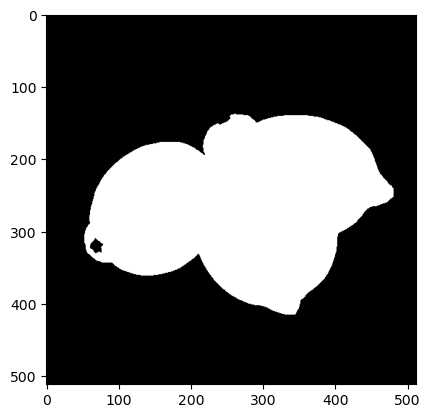

In [501]:
plt.imshow(new_mask,cmap=plt.cm.gray)

In [457]:
# color image
stim = 'yellow_lemons.png' 
path = os.path.join(true_color_stim_dir,stim)
color_img = cv2.imread(path)
color_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
cH, cL, cS = cv2.split(color_hls)

# read in the grayscaled image of the lemons
stim = 'lemons.png' 
path = os.path.join(grey_stim_dir,stim)
img = cv2.imread(path)

yellow = 30
blue = 120
# transform grayscaled image into HLS
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
H, L, S = cv2.split(hls)
H[new_mask==1] += yellow
hls_new = cv2.merge((H, L, cS))
H[new_mask==1] += blue
hls_inv = cv2.merge((H, L, cS))
new_img = cv2.cvtColor(hls_new, cv2.COLOR_HLS2RGB)
inv_img = cv2.cvtColor(hls_inv, cv2.COLOR_HLS2RGB)

#plt.imshow(new_img)

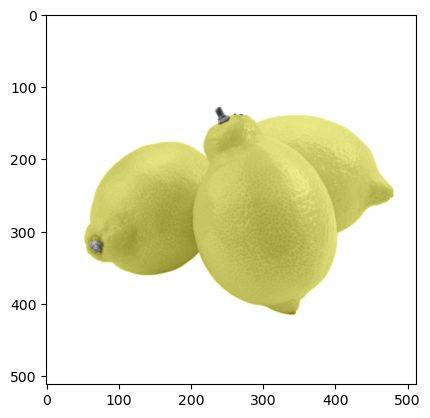

In [504]:
# read in the grayscaled image of the lemons
stim = 'lemons.png' 
path = os.path.join(grey_stim_dir,stim)
img = cv2.imread(path)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb[new_mask==1]-=rgb[new_mask==1].min()

yellow = np.array([100,100,0],dtype='uint8')
rgb[new_mask==1]+=yellow

plt.imshow(rgb)

an image of the colors for each hue value<br>

In [268]:
all_colors = np.zeros((100,180,3),dtype='uint8')
all_colors[:,:,0] = np.linspace(0,180,180)
all_colors[:,:,1] = 100
all_colors[:,:,2] = 150

all_colors_rgb = cv2.cvtColor(all_colors, cv2.COLOR_HLS2RGB)

fig = plt.figure()
plt.imshow(all_colors_rgb)
plt.savefig(os.path.join(mask_dir,'hue_distribution.png'))
plt.close(fig=fig)